# Wasserstein Distances

Import Libraries

In [1]:
import os
import random
import glob
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.stats as stats

sys.path.append(os.path.abspath('./../../sdo_augmentation/'))
from augmentation_test import read_image
from augmentation_list import AugmentationList
from augmentation import Augmentations

# Investigating Rotation

Select image and rotate the image in 10 different ways

Degree: 5 Wasserstein Distance: 21089.242609104527
Degree: 10 Wasserstein Distance: 37266.75170194193
Degree: 15 Wasserstein Distance: 48360.887365771276
Degree: 20 Wasserstein Distance: 55831.904638258384
Degree: 25 Wasserstein Distance: 60922.423987785456
Degree: 30 Wasserstein Distance: 64073.29392378374
Degree: 35 Wasserstein Distance: 66024.70288310706
Degree: 40 Wasserstein Distance: 67179.06756000838
Degree: 45 Wasserstein Distance: 67640.86141562216


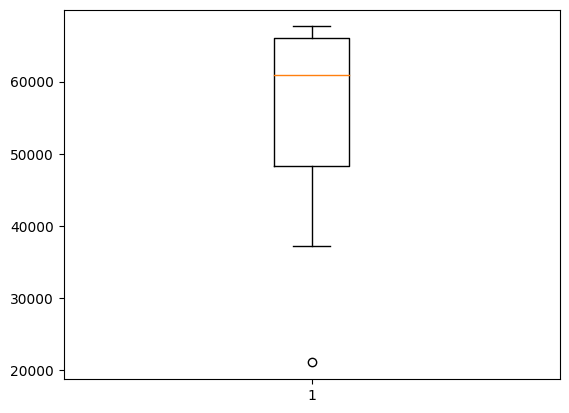

In [35]:
# Open image
image_path = './../../AIA171_Miniset_BW/20130217_000001_aia_171_4k/tiles/20130217_000001_aia_171_4k_tile_1024_3072.jpg'
image = np.array(Image.open(image_path).convert('L'))
image = image.astype(float) / 255

# Create set of degrees to rotate
set_degrees = np.arange(0, 50, 5)
rotated_images = []
power_spectrums = []
wasserstein_distances = []
pixel_count = image.shape[0]


for j, i in enumerate(set_degrees):
    
    # Create rotated image
    augmentation = Augmentations(image, {'rotate': i})
    rotated_image, _ = augmentation.perform_augmentations()
    rotated_images.append(rotated_image)

    # Convert into fourier transform
    fourier_rotated_image = np.fft.fftn(rotated_image)
    fourier_rotated_amplitudes = np.abs(fourier_rotated_image)

    #Calculate 1D power spectrum
    k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
    k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
    k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
    k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                        (fourier_rotated_amplitudes ** 2).flatten(),
                                        statistic = "mean", bins = k_bins)
    a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)

    power_spectrums.append(a_bins)

    # Calculate Wasserstein Distance of original image vs rotated iamge
    if not i == 0:
        wasserstein_distance = stats.wasserstein_distance(power_spectrums[0], power_spectrums[j])
        wasserstein_distances.append(wasserstein_distance)
        print('Degree:', i, 'Wasserstein Distance:', wasserstein_distance)

   

# Display a box plot 
plt.boxplot(wasserstein_distances)
plt.show()


Compare Origional Image with Augmented Image

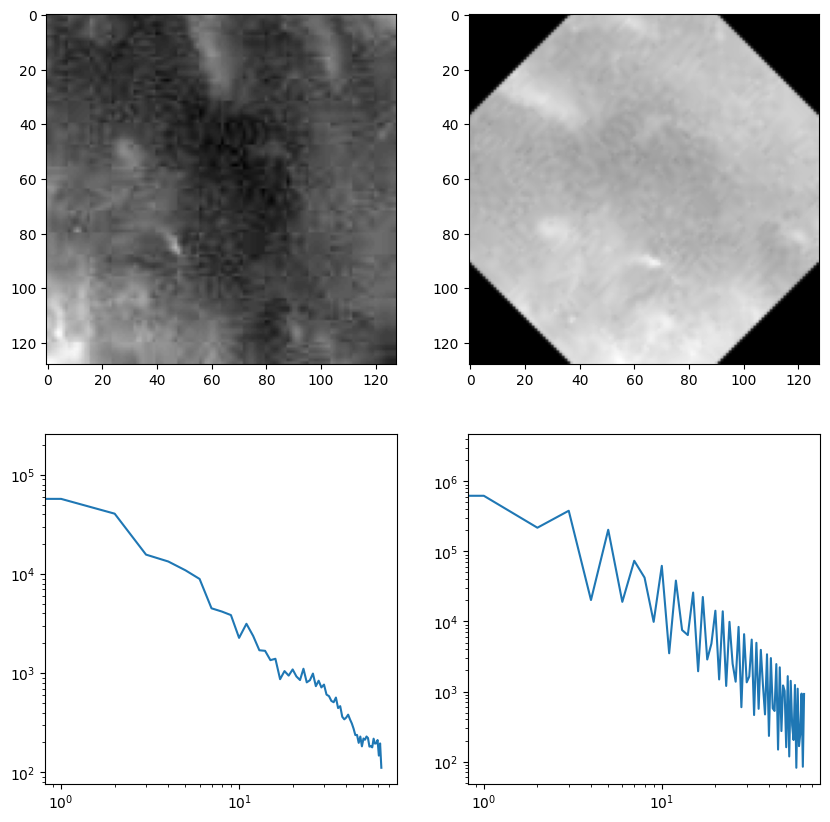

In [42]:
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

index = 9

axs[0, 0].imshow(rotated_images[0], cmap = 'gray')
axs[1, 0].loglog(power_spectrums[0])
axs[0, 1].imshow(rotated_images[index], cmap = 'gray')
axs[1, 1].loglog(power_spectrums[index])

